In [1]:
import logging
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

Importing plotly failed. Interactive plots will not work.


# Model

In [2]:
def get_group_definition(X, pool_cols, pool_type):
    if pool_type == "complete":
        group = np.zeros(len(X), dtype="int")
        group_mapping = {0: "all"}
        n_groups = 1
    else:
        X[pool_cols] = pd.Categorical(X[pool_cols])
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups, group_mapping


class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        slope = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        intercept = self.data["y"].iloc[i0] - slope * self.data["t"].iloc[i0]
        return {
            "slope": slope,
            "intercept": intercept,
            "delta": 0.0,
            "beta": 0.0,
            "sigma": 1.0,
        }

    def fit(
        self,
        data,
        sigma_sd=0.5,
        mcmc_samples=0,
        chains=4,
        cores=4,
        use_prophet_initvals=True,
    ):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.initvals = {}
        # if use_prophet_initvals:
        #     self.initvals = self._model_init()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.initvals, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal(
                "sigma", sigma_sd, initval=self.initvals.get("sigma", 1)
            )
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=True, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    np.hstack(
                        (
                            self.data["ds"].unique().to_numpy(),
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_numpy(),
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecasts = self._predict(
            future, self.mcmc_samples, self.map_approx, self.trace
        )

        for group_code in range(forecasts.shape[0]):
            future[f"yhat_{group_code}"] = forecasts[group_code] * self.y_max
            for model_type, model_cnt in self.model_idxs.items():
                if model_type.startswith("fs"):
                    continue
                for model_idx in range(model_cnt):
                    future[f"{model_type}_{model_idx}_{group_code}"] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def plot(self, future, y_true=None, pool_cols=None):
        plt.figure(figsize=(14, 100 * 6))
        plt.subplot(100, 1, 1)
        plt.title("Predictions")
        plt.grid()

        group, n_groups, groups_ = get_group_definition(
            self.data, pool_cols, "not_complete"
        )
        for group_code, group_name in groups_.items():
            group_idx = group == group_code
            color = np.random.rand(3)
            plt.scatter(
                self.data["ds"][group_idx],
                self.data["y"][group_idx] * self.y_max,
                s=0.5,
                color=color,
                label=group_name,
            )

        if y_true is not None:
            test_group, test_n_groups, test_groups_ = get_group_definition(
                y_true, pool_cols, "not_complete"
            )
            for group_code, group_name in test_groups_.items():
                group_idx = test_group == group_code
                color = np.random.rand(3)
                plt.scatter(
                    y_true["ds"][group_idx],
                    y_true["y"][group_idx],
                    s=0.5,
                    color=color,
                    label=f"y - {group_name}",
                )

        for group_code, group_name in groups_.items():
            plt.plot(
                future["ds"],
                future[f"yhat_{group_code}"],
                lw=1,
                label=f"yhat - {group_name}",
            )

        plt.legend()
        plot_params = {"idx": 1}
        self._plot(plot_params, future, self.data, self.y_max, y_true)

    def metrics(self, y_true, future, pool_cols=None):
        metrics = {}
        test_group, test_n_groups, test_groups_ = get_group_definition(
            y_true, pool_cols, "not_complete"
        )
        for group_code, group_name in test_groups_.items():
            metrics[group_name] = {}
            group_idx = test_group == group_code
            y = y_true["y"][group_idx]
            yhat = future[f"yhat_{group_code}"][-len(y) :]
            metrics[group_name]["mse"] = mean_squared_error(y, yhat)
            metrics[group_name]["rmse"] = root_mean_squared_error(y, yhat)
            metrics[group_name]["mae"] = mean_absolute_error(y, yhat)
            metrics[group_name]["mape"] = mean_absolute_percentage_error(y, yhat)

        return pd.DataFrame(metrics)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
        pool_cols=None,
        pool_type="complete",
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        t = np.array(data["t"])
        hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
        cp_indexes = (
            np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        )
        self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))

        # * 1 casts the boolean to integers
        A = (t[:, None] > self.s) * 1

        with model:
            if self.pool_type == "partial":
                sigma_slope = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_slope", beta=self.slope_sd
                )
                offset_slope = pm.Normal(
                    f"lt_{self.model_idx} - offset_slope", mu=0, sigma=1, shape=n_groups
                )
                slope = pm.Deterministic(
                    f"lt_{self.model_idx} - slope", offset_slope * sigma_slope
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                sigma_delta = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_delta", beta=delta_sd
                )
                offset_delta = pm.Laplace(
                    f"lt_{self.model_idx} - offset_delta",
                    0,
                    1,
                    shape=(n_groups, self.n_changepoints),
                )
                delta = pm.Deterministic(
                    f"lt_{self.model_idx} - delta", offset_delta * sigma_delta
                )
            else:
                slope = pm.Normal(
                    f"lt_{self.model_idx} - slope",
                    self.slope_mean,
                    self.slope_sd,
                    initval=initvals.get("slope", None),
                    shape=n_groups,
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                delta = pm.Laplace(
                    f"lt_{self.model_idx} - delta",
                    self.delta_mean,
                    delta_sd,
                    shape=(n_groups, self.n_changepoints),
                )

            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
                initval=initvals.get("intercept", None),
                shape=n_groups,
            )

            gamma = -self.s * delta[group, :]

            trend = pm.Deterministic(
                f"lt_{self.model_idx} - trend",
                (slope[group] + pm.math.sum(A * delta[group], axis=1)) * t
                + (intercept[group] + pm.math.sum(A * gamma, axis=1)),
            )

        return trend

    def _predict_map(self, future, map_approx):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            forecasts.append(
                np.array(
                    (
                        map_approx[f"lt_{self.model_idx} - slope"][group_code]
                        + np.dot(
                            new_A,
                            map_approx[f"lt_{self.model_idx} - delta"][group_code],
                        )
                    )
                    * future["t"]
                    + (
                        map_approx[f"lt_{self.model_idx} - intercept"][group_code]
                        + np.dot(
                            new_A,
                            (
                                -self.s
                                * map_approx[f"lt_{self.model_idx} - delta"][group_code]
                            ),
                        )
                    )
                )
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            delta = (
                trace["posterior"][f"lt_{self.model_idx} - delta"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            slope = (
                trace["posterior"][f"lt_{self.model_idx} - slope"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            intercept = (
                trace["posterior"][f"lt_{self.model_idx} - intercept"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )

            forecasts.append(
                (
                    (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
                    + (intercept + np.dot(new_A, (-self.s * delta).T)).T
                ).mean(0)
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"lt_{self.model_idx}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                future["ds"],
                future[f"lt_{self.model_idx}_{group_code}"],
                lw=1,
                label=group_name,
            )

        plt.legend()


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        shrinkage_strength=100,
        pool_cols=None,
        pool_type="complete",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd
        self.shrinkage_strength = shrinkage_strength

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([beta_initval] * 2 * self.series_order)

        with model:
            if self.pool_type == "partial":
                mu_beta = pm.Normal(
                    f"fs_{self.model_idx} - beta_mu(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=2 * self.series_order,
                    initval=beta_initval,
                )
                sigma_beta = pm.HalfNormal(
                    f"fs_{self.model_idx} - beta_sigma(p={self.period},n={self.series_order})",
                    sigma=self.beta_sd / self.shrinkage_strength,
                    shape=2 * self.series_order,
                )
                offset_beta = pm.Normal(
                    f"fs_{self.model_idx} - offset_beta(p={self.period},n={self.series_order})",
                    mu=0,
                    sigma=1,
                    shape=(n_groups, 2 * self.series_order),
                )

                beta = pm.Deterministic(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu_beta + offset_beta * sigma_beta,
                )
            else:
                beta = pm.Normal(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=(n_groups, 2 * self.series_order),
                    initval=beta_initval,
                )

        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[-int(self.period) :],
                future[f"fs_{self.model_idx}_{group_code}"][-int(self.period) :],
                lw=1,
                label=group_name,
            )

        plt.legend()


class Constant(TimeSeriesModel):
    def __init__(self, lower, upper, pool_cols=None, pool_type="complete"):
        self.lower = lower
        self.upper = upper
        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["c"] = model_idxs.get("c", 0)
        self.model_idx = model_idxs["c"]
        model_idxs["c"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        with model:
            if self.pool_type == "partial":
                mu_c = pm.Uniform(
                    f"c_{self.model_idx} - mu_c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )
                offset_c = pm.Normal(
                    f"c_{self.model_idx} - offset_c(l={self.lower},u={self.upper})",
                    mu=0,
                    sigma=1,
                    shape=n_groups,
                )
                c = pm.Deterministic(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    mu_c + offset_c,
                )
            else:
                c = pm.Uniform(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )

        return c[group]

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * map_approx[f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"][
                    group_code
                ]
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * trace["posterior"][
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"
                ]
                .to_numpy()[:, :, group_code]
                .mean()
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"c_{self.model_idx} - c(l={self.lower},u={self.upper})")

        plot_data = []
        for group_code, group_name in self.groups_.items():
            plot_data.append(
                (group_name, future[f"c_{self.model_idx}_{group_code}"][0])
            )

        plt.bar(*zip(*plot_data))
        plt.axhline(0, c="k", linewidth=3)

# Fetch data

In [3]:
indexes = ["^W5000", "^GSPC", "^IXIC", "^DJI"]

gspc_tickers = [
    "AAPL", "MSFT", "AMZN", "FB", "TSLA", "GOOGL", "GOOG", "JNJ", "JPM", "V",
    "PG", "UNH", "DIS", "NVDA", "MA", "HD", "PYPL", "VZ", "ADBE", "CMCSA",
    "NFLX", "BAC", "KO", "MRK", "PEP", "T", "PFE", "INTC", "CRM", "WMT", "ABT",
    "ABBV", "CSCO", "TMO", "NKE", "AVGO", "XOM", "QCOM", "COST", "ACN", "CVX",
    "MCD", "MDT", "NEE", "TXN", "HON", "DHR", "UNP", "BMY", "LIN", "LLY",
    "AMGN", "PM", "C", "SBUX", "WFC", "ORCL", "UPS", "LOW", "BA", "IBM", "AMD",
    "RTX", "NOW", "BLK", "MMM", "INTU", "AMT", "CAT", "MS", "CHTR", "ISRG",
    "GE", "BKNG", "GS", "CVS", "TGT", "FIS", "LMT", "DE", "MU", "MDLZ", "TJX",
    "SYK", "ANTM", "SCHW", "SPGI", "AXP", "AMAT", "TMUS", "ZTS", "MO", "ADP",
    "CI", "PLD", "CL", "GILD", "BDX", "ATVI", "CB", "CSX", "CCI", "LRCX",
    "DUK", "ADSK", "FISV", "CME", "SO", "ICE", "TFC", "GPN", "USB", "EQIX",
    "PNC", "FDX", "VRTX", "D", "APD", "NSC", "EL", "SHW", "MMC", "ITW", "PGR",
    "EW", "ADI", "HUM", "ILMN", "ECL", "GM", "DD", "DG", "BSX", "REGN", "AON",
    "NEM", "EMR", "ETN", "NOC", "MCO", "KMB", "WM", "COF", "ROP", "CTSH",
    "ROST", "HCA", "TWTR", "COP", "IDXX", "EA", "AEP", "EXC", "DOW", "BAX",
    "TEL", "KLAC", "LHX", "SNPS", "APH", "DLR", "CMG", "ALGN", "CDNS", "SYY",
    "FCX", "BIIB", "STZ", "MSCI", "SRE", "A", "MCHP", "GIS", "MET", "TRV",
    "DXCM", "APTV", "PSA", "PH", "MAR", "XEL", "TT", "CNC", "XLNX", "GD", "BK",
    "F", "IQV", "TROW", "ALXN", "MNST", "PPG", "HPQ", "VRSK", "JCI", "TDG",
    "CMI", "INFO", "ALL", "EBAY", "ORLY", "YUM", "AIG", "ZBH", "SBAC", "ANSS",
    "CTAS", "PRU", "HLT", "RMD", "CARR", "PSX", "BLL", "SLB", "PCAR", "PAYX",
    "ES", "PEG", "ROK", "EOG", "AFL", "WEC", "CTVA", "MSI", "WBA", "SWK",
    "ADM", "FAST", "SPG", "MCK", "AME", "AWK", "DFS", "LUV", "OTIS", "GLW",
    "AZO", "VFC", "WLTW", "MTD", "WELL", "MPC", "KMI", "CPRT", "STT", "DAL",
    "FRC", "CLX", "DLTR", "SWKS", "WY", "ED", "KR", "KEYS", "WMB", "CERN",
    "TTWO", "FTV", "AJG", "EIX", "MKC", "MXIM", "LYB", "DTE", "EFX", "VLO",
    "BBY", "AMP", "DHI", "FLT", "VTRS", "HSY", "KHC", "AVB", "PAYC", "ETSY",
    "O", "VRSN", "PPL", "CHD", "MKTX", "ARE", "VIAC", "CBRE", "LEN", "WST",
    "ZBRA", "EQR", "RSG", "SIVB", "FTNT", "ETR", "TER", "LH", "VMC", "FITB",
    "LVS", "IP", "NTRS", "AEE", "TFX", "KSU", "QRVO", "TSN", "SYF", "CDW",
    "ODFL", "PXD", "HOLX", "AMCR", "GWW", "VTR", "XYL", "DOV", "EXPE", "GRMN",
    "COO", "CAG", "BR", "MLM", "TYL", "HIG", "CMS", "CTLT", "AKAM", "OKE",
    "IR", "WDC", "URI", "HAL", "FE", "TSCO", "MTB", "PEAK", "INCY", "ULTA",
    "STE", "CCL", "EXPD", "PKI", "NUE", "DGX", "KEY", "CTXS", "VAR", "K",
    "ANET", "CAH", "ALB", "AES", "DRI", "KMX", "RF", "ESS", "WAT", "CFG",
    "HPE", "NDAQ", "CE", "DPZ", "IEX", "EXR", "POOL", "FMC", "DRE", "NTAP",
    "ABMD", "OXY", "MAA", "GPC", "TDY", "HES", "ABC", "MAS", "IT", "NVR",
    "TIF", "J", "LDOS", "BKR", "STX", "RCL", "EMN", "OMC", "BXP", "SJM", "WAB",
    "HRL", "PKG", "CINF", "AVY", "MGM", "LNT", "HBAN", "CHRW", "PFG", "UAL",
    "EVRG", "BIO", "JKHY", "NLOK", "HAS", "ATO", "FBHS", "CNP", "RJF", "IFF",
    "PHM", "LW", "CXO", "XRAY", "WRK", "JBHT", "UDR", "WHR", "HWM", "TXT",
    "WYNN", "FFIV", "ALLE", "AAP", "UHS", "L", "LYV", "HST", "CBOE", "PWR",
    "LKQ", "FOXA", "CPB", "AAL", "LUMN", "HSIC", "BWA", "RE", "WRB", "SNA",
    "IPG", "NRG", "GL", "LNC", "WU", "PNW", "PNR", "NI", "LB", "DVA", "ROL",
    "TPR", "TAP", "IRM", "MHK", "CF", "AIZ", "NCLH", "NWL", "DISH", "IPGP",
    "MOS", "CMA", "DISCK", "FANG", "NLSN", "AOS", "JNPR", "REG", "ZION", "RHI",
    "SEE", "NWSA", "HII", "BEN", "PVH", "IVZ", "DXC", "COG", "KIM", "ALK",
    "PRGO", "DVN", "LEG", "FRT", "VNO", "FLIR", "PBCT", "APA", "NOV", "MRO",
    "HBI", "RL", "DISCA", "FLS", "UNM", "VNT", "FOX", "SLG", "GPS", "FTI",
    "XRX", "HFC", "UAA", "UA", "NWS"
]

dji_tickers = [
    "DIS", "WMT", "DOW", "NKE", "CRM", "HD", "V", "MSFT", "MMM", "CSCO", "KO",
    "AAPL", "HON", "JNJ", "TRV", "PG", "CVX", "VZ", "CAT", "BA", "AMGN", "IBM",
    "AXP", "JPM", "WBA", "MCD", "MRK", "GS", "UNH", "INTC"
]

ixic_tickers = [
    "FEYE", "ATEC", "SLAB", "CMRX", "NVCR", "FNLC", "NMRK", "SCOR", "AGLE",
    "FARO", "OLMA", "TSLA", "FRTA", "AKTX", "KLXE", "CVCO", "NVCN", "EXAS",
    "SDC", "BBQ", "IFRX", "CIIC", "BBI", "FNKO", "TWST", "FARM", "ACCD",
    "NMRD", "FRSX", "OPTT"
]

all_tickers = indexes + list(set(gspc_tickers + dji_tickers + ixic_tickers))
len(all_tickers)

data = yfinance.download(
    all_tickers,
    interval="1d",
    start="2000-01-01",
    end="2020-01-01",
)
data

[*********************100%***********************]  536 of 536 completed

54 Failed downloads:
['NVCN', 'KSU', 'AGLE', 'BLL', 'SIVB', 'TIF', 'PXD', 'RE', 'FLIR', 'CXO', 'BBQ', 'DRE', 'MXIM', 'ANTM', 'WLTW', 'ALXN', 'FLT', 'DISCA', 'HFC', 'NLSN', 'CIIC', 'FEYE', 'FRTA', 'SDC', 'FBHS', 'TWTR', 'DISH', 'BBI', 'VIAC', 'CERN', 'FB', 'PBCT', 'ABC', 'ABMD', 'XLNX', 'PKI', 'COG', 'VAR', 'ATVI', 'WRK', 'PEAK', 'NLOK', 'FRC', 'GPS', 'DISCK', 'CTXS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['FISV', 'OTIS', 'VNT', 'LB', 'ACCD', 'OLMA', 'INFO', 'CARR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2000-01-01 -> 2020-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1577854800")')


Price       Adj Close                                                        \
Ticker              A        AAL         AAP       AAPL       ABBV ABC ABMD   
Date                                                                          
2000-01-03  43.463043        NaN         NaN   0.843077        NaN NaN  NaN   
2000-01-04  40.142937        NaN         NaN   0.771997        NaN NaN  NaN   
2000-01-05  37.652878        NaN         NaN   0.783293        NaN NaN  NaN   
2000-01-06  36.219189        NaN         NaN   0.715509        NaN NaN  NaN   
2000-01-07  39.237438        NaN         NaN   0.749401        NaN NaN  NaN   
...               ...        ...         ...        ...        ...  ..  ...   
2019-12-24  82.411530  29.072563  145.651291  68.898705  72.506973 NaN  NaN   
2019-12-26  82.556458  29.560759  144.472076  70.265671  72.490829 NaN  NaN   
2019-12-27  82.527473  28.335287  143.637558  70.238998  71.982437 NaN  NaN   
2019-12-30  82.198288  28.195801  144.335999  70.655884  71.433701 NaN  NaN   
2019-12-31  82.595245  28.574404  145.279373  71.172142  71.449821 NaN  NaN   

Price                                   ...    Volume                     \
Ticker            ABT ACCD         ACN  ...       XYL      YUM       ZBH   
Date                                    ...                                
2000-01-03   8.288182  NaN         NaN  ...       NaN  3033493       NaN   
2000-01-04   8.051374  NaN         NaN  ...       NaN  3315031       NaN   
2000-01-05   8.036576  NaN         NaN  ...       NaN  4642602       NaN   
2000-01-06   8.317780  NaN         NaN  ...       NaN  3947658       NaN   
2000-01-07   8.406585  NaN         NaN  ...       NaN  6063647       NaN   
...               ...  ...         ...  ...       ...      ...       ...   
2019-12-24  79.992393  NaN  196.620178  ...  184600.0   656400  252350.0   
2019-12-26  79.992393  NaN  197.028976  ...  427500.0  1176900  630051.0   
2019-12-27  80.102394  NaN  197.186966  ...  346700.0  1130500  403657.0   
2019-12-30  79.552483  NaN  195.718857  ...  523800.0  1185800  607494.0   
2019-12-31  79.607468  NaN  195.653854  ...  492000.0  1271000  630772.0   

Price                                                                       \
Ticker         ZBRA     ZION        ZTS       ^DJI       ^GSPC       ^IXIC   
Date                                                                         
2000-01-03  1055700  1199600        NaN  169750000   931800000  1510070000   
2000-01-04   522450   816100        NaN  178420000  1009000000  1511840000   
2000-01-05   612225  1124700        NaN  203190000  1085500000  1735670000   
2000-01-06   263925  1112100        NaN  176550000  1092300000  1598320000   
2000-01-07   333900   782000        NaN  184900000  1225200000  1634930000   
...             ...      ...        ...        ...         ...         ...   
2019-12-24   164400   312600   442500.0   86150000  1296530000  1014530000   
2019-12-26   255200   586400   929400.0  155970000  2164540000  1639960000   
2019-12-27   214100   921600  1296100.0  182280000  2429150000  1833740000   
2019-12-30   339100  1511600   942000.0  181600000  3021720000  2051320000   
2019-12-31   363500  1246900  1128600.0  193340000  2894760000  2186830000   

Price              
Ticker     ^W5000  
Date               
2000-01-03    0.0  
2000-01-04    0.0  
2000-01-05    0.0  
2000-01-06    0.0  
2000-01-07    0.0  
...           ...  
2019-12-24    0.0  
2019-12-26    0.0  
2019-12-27    0.0  
2019-12-30    0.0  
2019-12-31    0.0  

[5031 rows x 3216 columns]

In [4]:
downloaded_tickers = list({col[1] for col in data.columns})
downloaded_tickers

['JKHY',
 'HPE',
 'C',
 'ALGN',
 'BAX',
 'NVCN',
 'WM',
 'ROK',
 'DLR',
 'ALB',
 'SBUX',
 'ACN',
 'MAR',
 'CCI',
 'KSU',
 'AGLE',
 'NOV',
 'RTX',
 'PFE',
 'LUMN',
 'PEG',
 'CNC',
 'CF',
 'SO',
 'EXPE',
 'EQR',
 'DXC',
 'ICE',
 'CMS',
 'MRO',
 'SLAB',
 'ULTA',
 'CMA',
 'LYV',
 'LNC',
 'WELL',
 'FMC',
 'AIZ',
 'BLL',
 'XRAY',
 'SLB',
 'URI',
 'SIVB',
 'TIF',
 'DAL',
 'NVCR',
 'NOC',
 'SYF',
 'BDX',
 'EVRG',
 'EXR',
 'EQIX',
 'AKAM',
 'BK',
 'EIX',
 'AON',
 'CVX',
 'AAPL',
 'CSCO',
 'BA',
 'PXD',
 'RSG',
 'AMGN',
 'AMT',
 'PEP',
 'RE',
 'CHRW',
 'MCHP',
 'APTV',
 'PRGO',
 'SCHW',
 'WAT',
 'EMR',
 'LMT',
 'TMO',
 'RL',
 'AMZN',
 'VRSK',
 'MET',
 'DPZ',
 'LVS',
 'ADI',
 'ARE',
 'BKR',
 'FARM',
 'LEN',
 'CINF',
 'MTD',
 'DXCM',
 'STX',
 'FLIR',
 'L',
 'ED',
 'ETN',
 'CBOE',
 'CXO',
 'DVA',
 'MAA',
 'AKTX',
 'LH',
 'ALLE',
 'BBQ',
 'WU',
 'LYB',
 'GOOG',
 'MCO',
 'TPR',
 'HAL',
 'SPG',
 'DRE',
 'RJF',
 'STZ',
 'MOS',
 'UNH',
 'COO',
 'UA',
 'TSCO',
 'NDAQ',
 'TT',
 'PG',
 'IPG',
 'TMUS',
 'WB

In [5]:
dfs = []
for ticker in ["^GSPC"] + gspc_tickers:
    if ticker not in downloaded_tickers:
        continue
    
    df = pd.DataFrame(
        data={
            "open": data["Open"][ticker].to_numpy(),
            "high": data["High"][ticker].to_numpy(),
            "low": data["Low"][ticker].to_numpy(),
            "close": data["Adj Close"][ticker].to_numpy(),
            "typical_price": ((data["Open"][ticker] + data["High"][ticker] + data["Low"][ticker] + data["Close"][ticker]) / 4).to_numpy(),
        }, 
        index=data["Adj Close"][ticker].index
    )
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_date_range).interpolate()
    df["ds"] = df.index
    df.reset_index(drop=True, inplace=True)
    df["series"] = ticker
    dfs.append(df)

# Experiments

In [6]:
def generate_train_test_df(start, window, horizon, dfs, for_prophet=False):
    train_dfs = []
    test_dfs = []
    scales = []
    for df in dfs:
        if df.isna().any().any():
            continue
        
        train_df = df[start:start + window].copy()
        scales.append(train_df["typical_price"].max())
        train_df["y"] = train_df["typical_price"] / scales[-1]
        test_df = df[start + window:start + window + horizon].copy()
        test_df["y"] = test_df["typical_price"] / scales[-1]
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    if for_prophet:
        return train_dfs, test_dfs, scales

    return pd.concat(train_dfs), pd.concat(test_dfs), scales

## 2008 financial crisis

In [7]:
def generate_train_test_df_financial_crisis(window, horizon, dfs, for_prophet=False):
    year_after_financial_crisis_idx = len(dfs[0][dfs[0]["ds"] < "2009-09-01"])
    start = year_after_financial_crisis_idx - window
    return generate_train_test_df(start, window, horizon, dfs, for_prophet)

In [8]:
train_df_1, test_df_1, scales_1 = generate_train_test_df_financial_crisis(
    window=365 * 9, horizon=365, dfs=dfs[:1]
)
train_df_2, test_df_2, scales_2 = generate_train_test_df_financial_crisis(
    window=365 * 1, horizon=365, dfs=dfs[1:3]
)
train_df = pd.concat((train_df_1, train_df_2))
test_df = pd.concat((test_df_1, test_df_2))
train_df

,open,high,low,close,typical_price,ds,series,y
244,1519.225037,1525.429993,1509.869995,1513.924988,1517.112503,2000-09-03,^GSPC,0.971212
245,1519.997528,1523.100006,1507.039978,1510.502472,1515.159996,2000-09-04,^GSPC,0.969962
246,1520.770020,1520.770020,1504.209961,1507.079956,1513.207489,2000-09-05,^GSPC,0.968712
247,1507.079956,1512.609985,1492.119995,1492.250000,1501.014984,2000-09-06,^GSPC,0.960906
248,1492.250000,1505.339966,1492.250000,1502.510010,1498.087494,2000-09-07,^GSPC,0.959032
...,...,...,...,...,...,...,...,...
3524,24.410000,24.780001,24.299999,18.506042,24.545000,2009-08-27,MSFT,0.894966
3525,25.070000,25.490000,24.610001,18.498549,24.962500,2009-08-28,MSFT,0.910189
3526,24.903333,25.276667,24.503334,18.491051,24.838333,2009-08-29,MSFT,0.905662
3527,24.736666,25.063334,24.396667,18.483553,24.714167,2009-08-30,MSFT,0.901134


In [9]:
test_df

,open,high,low,close,typical_price,ds,series,y
3529,1019.520020,1028.449951,996.280029,998.039978,1010.572495,2009-09-01,^GSPC,0.646939
3530,996.070007,1000.340027,991.969971,994.750000,995.782501,2009-09-02,^GSPC,0.637471
3531,996.119995,1003.429993,992.250000,1003.239990,998.759995,2009-09-03,^GSPC,0.639377
3532,1003.840027,1016.479980,1001.650024,1016.400024,1009.592514,2009-09-04,^GSPC,0.646312
3533,1007.547516,1018.877472,1005.905014,1018.647522,1012.744381,2009-09-05,^GSPC,0.648330
...,...,...,...,...,...,...,...,...
3889,23.879999,24.020000,23.510000,18.278591,23.835000,2010-08-27,MSFT,0.869078
3890,23.833333,23.953334,23.540000,18.204751,23.790000,2010-08-28,MSFT,0.867437
3891,23.786666,23.886667,23.570000,18.130910,23.745000,2010-08-29,MSFT,0.865796
3892,23.740000,23.820000,23.600000,18.057070,23.700000,2010-08-30,MSFT,0.864155


In [10]:
model = LinearTrend(pool_cols="series", pool_type="partial", n_changepoints=25) * (
    Constant(-1, 1, pool_cols="series", pool_type="partial")
    * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
    + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
)
model.fit(train_df, use_prophet_initvals=False)
yhat = model.predict(365)
model.metrics(test_df, yhat, pool_cols="series")

Output()

,AAPL,MSFT,^GSPC
mse,0.327799,0.097248,0.003541
rmse,0.572537,0.311846,0.059509
mae,0.552048,0.263235,0.053541
mape,0.422478,0.248998,0.075115


In [11]:
train_df_prophet, test_df_prophet, scales_prophet = (
    generate_train_test_df_financial_crisis(
        window=365 * 1, horizon=365, dfs=dfs[1:3], for_prophet=True
    )
)
train_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
3164,6.162143,6.196429,5.928929,5.031910,6.063170,2008-09-01,AAPL,0.993759
3165,6.157143,6.196429,5.892857,5.006754,6.045447,2008-09-02,AAPL,0.990854
3166,5.958571,6.024286,5.857143,5.029952,5.950714,2008-09-03,AAPL,0.975327
3167,5.923571,5.996786,5.743214,4.857024,5.855357,2008-09-04,AAPL,0.959698
3168,5.663929,5.800000,5.630357,4.825692,5.703750,2008-09-05,AAPL,0.934849
...,...,...,...,...,...,...,...,...
3524,6.026786,6.056071,5.886786,5.104967,6.005357,2009-08-27,AAPL,0.984283
3525,6.152500,6.160357,6.018929,5.123041,6.101250,2009-08-28,AAPL,1.000000
3526,6.103571,6.117024,5.994762,5.104564,6.066667,2009-08-29,AAPL,0.994332
3527,6.054643,6.073690,5.970596,5.086087,6.032083,2009-08-30,AAPL,0.988664


In [12]:
test_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
3529,5.999643,6.071429,5.890714,4.979941,5.966339,2009-09-01,AAPL,0.977888
3530,5.879286,5.986071,5.861071,4.976325,5.906428,2009-09-02,AAPL,0.968069
3531,5.944286,5.967857,5.892857,5.017598,5.938303,2009-09-03,AAPL,0.973293
3532,5.974286,6.096429,5.967500,5.130877,6.030179,2009-09-04,AAPL,0.988351
3533,6.025179,6.118214,6.011339,5.150609,6.065156,2009-09-05,AAPL,0.994084
...,...,...,...,...,...,...,...,...
3889,8.633929,8.664643,8.412857,7.279208,8.585179,2010-08-27,AAPL,1.407118
3890,8.622143,8.702024,8.473809,7.288046,8.609435,2010-08-28,AAPL,1.411094
3891,8.610357,8.739405,8.534761,7.296884,8.633690,2010-08-29,AAPL,1.415069
3892,8.598571,8.776786,8.595714,7.305722,8.657946,2010-08-30,AAPL,1.419045


In [13]:
prophet_forecasts = []

for df, df_test in zip(train_df_prophet, test_df_prophet):
    prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        seasonality_mode="multiplicative",
    )
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, include_history=True)
    prophet_forecasts.append(prophet.predict(future))
    print(
        f"{df["series"].iloc[0]}-mape: {mean_absolute_percentage_error(df_test["y"], prophet_forecasts[-1][-365:]["yhat"])}"
    )

AAPL-mape: 0.464602906526762
MSFT-mape: 0.28490221514904435


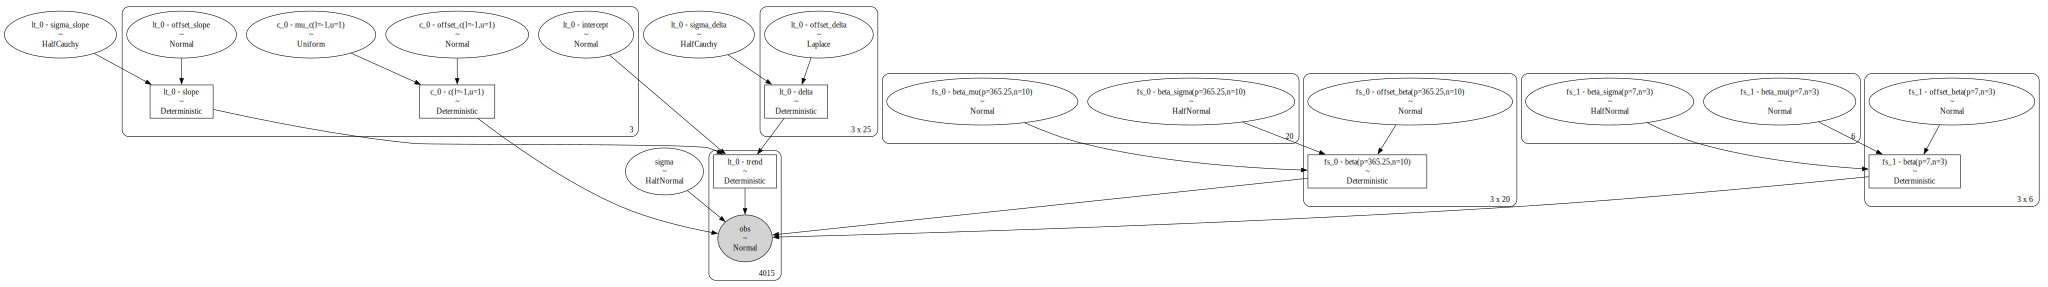

In [14]:
pm.model_to_graphviz(model.model)

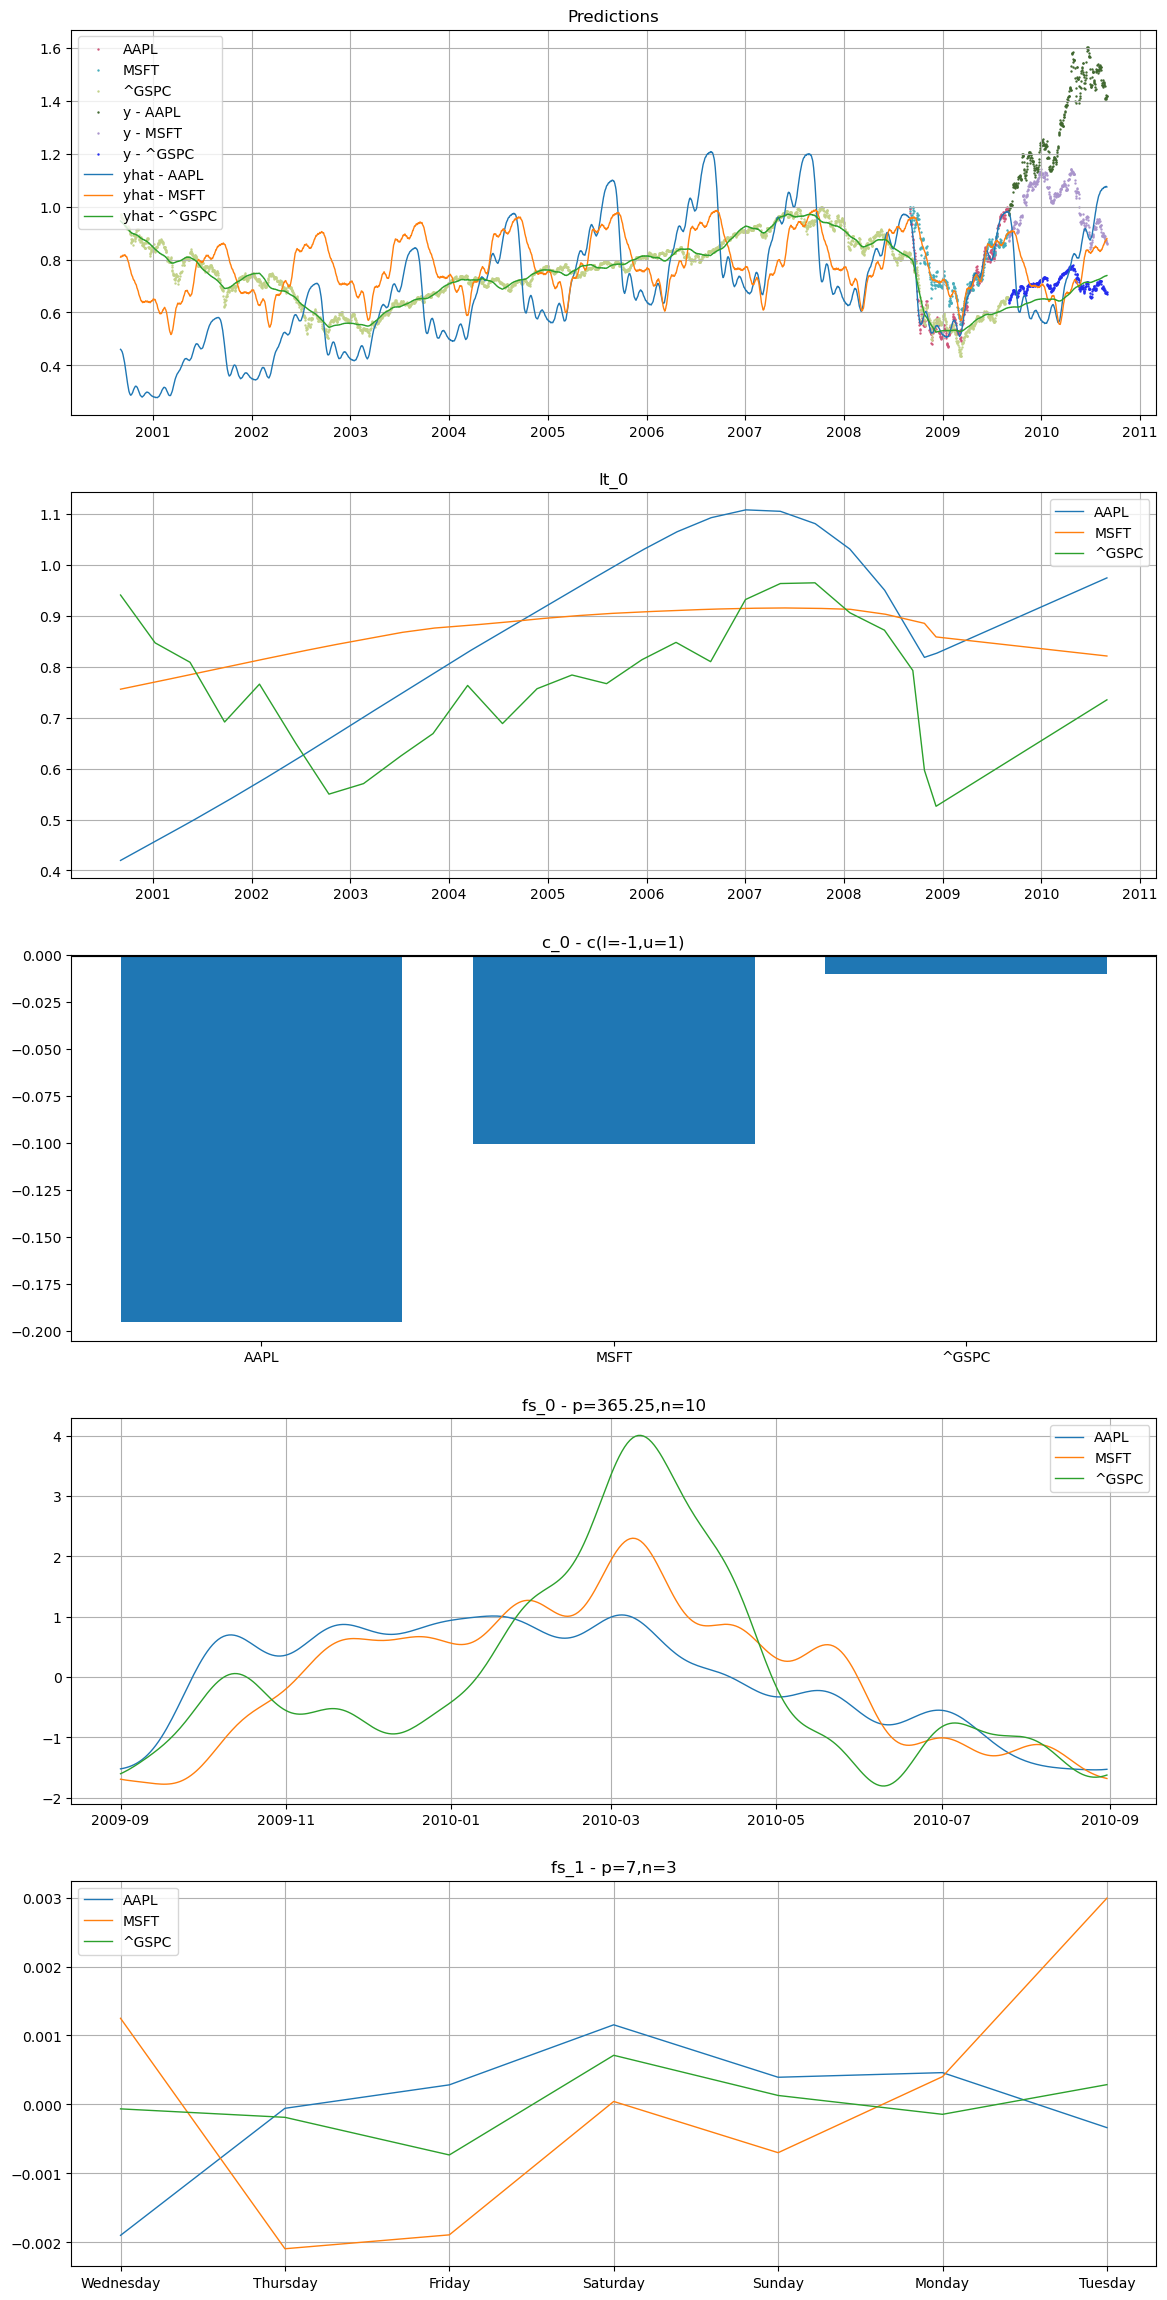

In [15]:
model.plot(yhat, y_true=test_df, pool_cols="series")